In [1]:
from time import time

import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import matplotlib.pyplot as plt
from scipy.stats import norm
np.random.seed(42)

In [2]:
def transition(x):
    return (np.sin(4 * np.pi * x)) * np.exp(-x/2) + 1.

bounds = [0, np.pi]

def plot_pred(pred_fun, true_fun, fig_ax=None):
    x_grid = np.linspace(*bounds, 101)
    y_true = true_fun(x_grid)
    y_pred_mu, y_pred_sigma = pred_fun(x_grid.reshape((-1, 1)))
    y_pred_mu, y_pred_sigma = y_pred_mu.ravel(), y_pred_sigma.ravel()
    if fig_ax:
        fig, ax = fig_ax
    else:
        fig, ax = plt.subplots(figsize=(12, 7))
    ax.fill_between(x_grid, y_pred_mu + 1.96 * y_pred_sigma, y_pred_mu - 1.96 * y_pred_sigma, label="95 % CI",
                    color="g", alpha=0.5)
    ax.plot(x_grid, y_pred_mu, color="r", label="GP mean")
    ax.plot(x_grid, y_true, "--b", label="true")
    ax.set_ylabel("x[t]")
    ax.set_xlabel("x[t - 1]")
    ax.grid()
    return fig, ax

def train(data_x, data_y):
    model = GaussianProcessRegressor(kernel=RBF(), n_restarts_optimizer=5, random_state=42)
    model.fit(data_x, data_y)
    def pred_fun(x):
        return model.predict(x.reshape((-1, data_x.shape[1])), return_std=True)
    return model, pred_fun


    

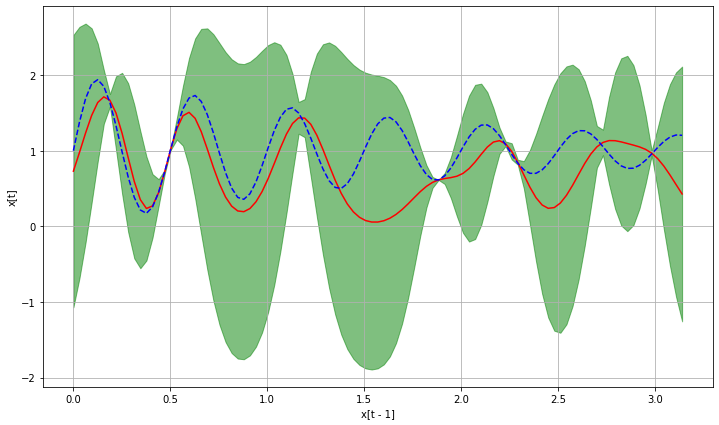

In [3]:
X = np.random.uniform(*bounds, (10, 1))
Y = transition(X)
model, pred_fun = train(X, Y)
_ = plot_pred(pred_fun, transition)

In [4]:
prev_point = np.array([[.25]])
cur_mu, cur_sigma = pred_fun(prev_point)
print(cur_mu, cur_sigma)

[[1.24316463]] [0.40209835]


In [5]:
# Propagate the uncertainty using the true function and sampling approximation
posterior = norm(cur_mu.ravel(), cur_sigma.ravel())
input_samples = posterior.rvs((2000, 1))
output_samples = transition(input_samples)

0.9977646926145693 0.3909119755210874


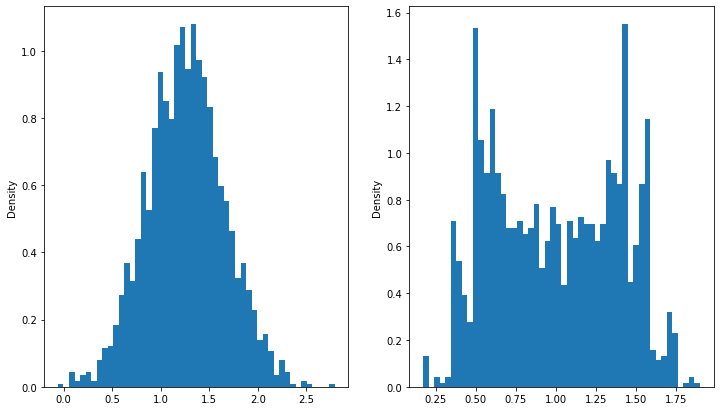

In [6]:
def histograms(*data, n_bins=50):
    fig, ax = plt.subplots(1, len(data), figsize=(12,7))
    for i, d in enumerate(data):
        ax[i].hist(d.ravel(), bins=n_bins, density=True)
        ax[i].set_ylabel("Density")
histograms(input_samples, output_samples)
next_mu_true = output_samples.mean()
next_sigma_true = output_samples.std(ddof=1)
print(next_mu_true, next_sigma_true)

0.88591470414472 1.0695878594102877


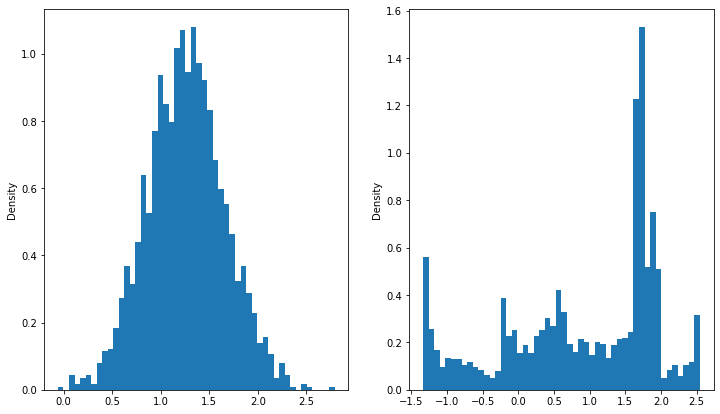

In [7]:
# Sampling from posterior for GP approximation
output_preds = model.sample_y(input_samples)
histograms(input_samples, output_preds)
next_mu_pred = output_preds.mean()
next_sigma_pred = output_preds.std(ddof=1)
print(next_mu_pred, next_sigma_pred)

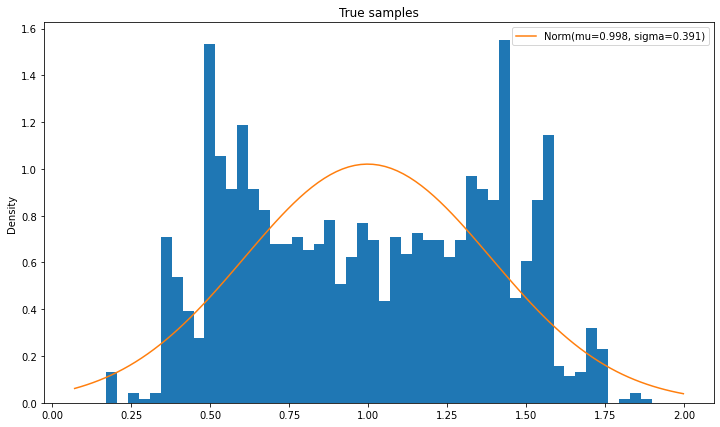

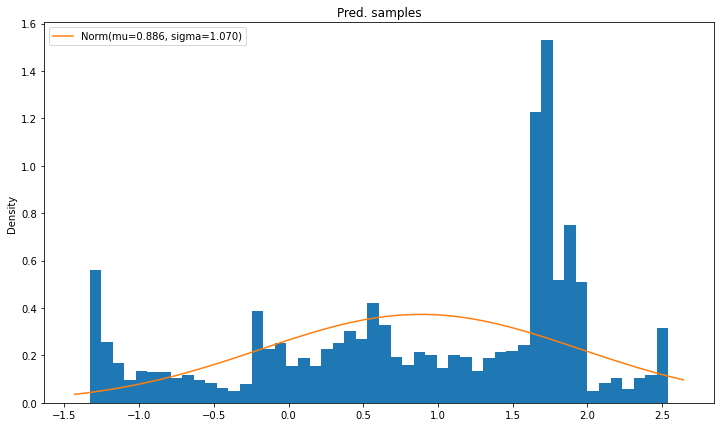

In [8]:
# Moment matching approximation
def compare_pdfs(data, pdf_funs, title, labels=None, n_bins=50):
    fig, ax = plt.subplots(figsize=(12, 7))
    ax.hist(data.ravel(), bins=50, density=True)
    x_grid = np.linspace(data.min() - 0.1, data.max() + 0.1, 101, "Data")
    for i_fun, pdf_fun in enumerate(pdf_funs):
        if labels is None:
            label = "PDF " + str(i_fun + 1)
        else:
            label = labels[i_fun]
        ax.plot(x_grid, pdf_fun(x_grid), label=label)
    ax.set_ylabel("Density")
    ax.set_title(title)
    ax.legend()

def norm_label(mu, sigma):
    return f"Norm(mu={mu:.3f}, sigma={sigma:.3f})"

compare_pdfs(output_samples, [norm(next_mu_true, next_sigma_true).pdf], "True samples",
             labels=[norm_label(next_mu_true, next_sigma_true)])
compare_pdfs(output_preds, [norm(next_mu_pred, next_sigma_pred).pdf], "Pred. samples", 
            labels=[norm_label(next_mu_pred, next_sigma_pred)])

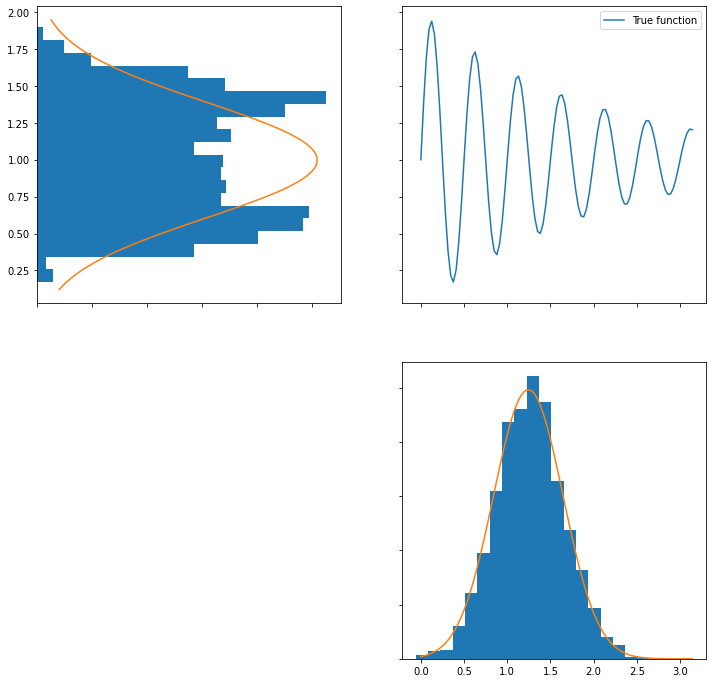

In [9]:
# Le big picture
def plot_big_picture_true(true_fun, samples, inp_pdf, n_bins=20):
    x_grid = np.linspace(*bounds, 101)
    y_true = true_fun(x_grid)
    out_samples = true_fun(samples)
    out_pdf = norm(out_samples.mean(), out_samples.std(ddof=1)).pdf
    fig, ax = plt.subplots(2, 2, figsize=(12, 12), sharex="col", sharey="row")
    ax[0, 1].plot(x_grid, y_true, label="True function")
    ax[0, 1].legend()
    ax[1, 1].hist(samples, bins=n_bins, density=True)
    y_grid = np.linspace(out_samples.min() - 0.05, out_samples.max() + 0.05, 101)
    ax[1, 1].plot(x_grid, inp_pdf(x_grid).ravel())
    ax[0, 0].hist(out_samples, orientation="horizontal", bins=n_bins, density=True)
    ax[0, 0].plot(out_pdf(y_grid).ravel(), y_grid)
    ax[1, 0].axis("off")
plot_big_picture_true(transition, input_samples, norm(cur_mu, cur_sigma).pdf, )

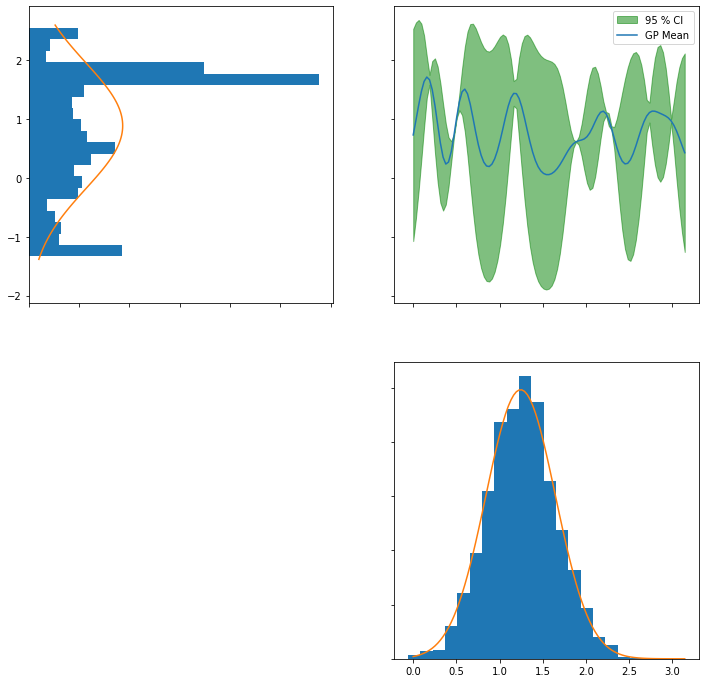

In [10]:
# Le big picture 2
def plot_big_picture_sample_pred(model, samples, inp_pdf, n_bins=20):
    x_grid = np.linspace(*bounds, 101)
    y_mu, y_sigma = model.predict(x_grid.reshape((-1, 1), ), return_std=True)
    y_mu, y_sigma = y_mu.ravel(), y_sigma.ravel()
    out_samples = model.sample_y(samples).ravel()
    out_pdf = norm(out_samples.mean(), out_samples.std(ddof=1)).pdf
    fig, ax = plt.subplots(2, 2, figsize=(12, 12), sharex="col", sharey="row")
    ax[0, 1].fill_between(x_grid, y_mu + 1.96 * y_sigma, y_mu - 1.96 * y_sigma,
                          label="95 % CI", color="g", alpha=0.5)
    ax[0, 1].plot(x_grid, y_mu, label="GP Mean")
    ax[0, 1].legend()
    ax[1, 1].hist(samples, bins=n_bins, density=True)
    ax[1, 1].plot(x_grid, inp_pdf(x_grid).ravel())
    ax[0, 0].hist(out_samples, orientation="horizontal", bins=n_bins, density=True)
    y_grid = np.linspace(out_samples.min() - 0.05, out_samples.max() + 0.05, 101)
    ax[0, 0].plot(out_pdf(y_grid).ravel(), y_grid)
    ax[1, 0].axis("off")
plot_big_picture_sample_pred(model, input_samples, norm(cur_mu, cur_sigma).pdf, )

mu: 0.867533918639736 0.1590960143325786
sigma: 0.9769986091821927 1.1874826216007126


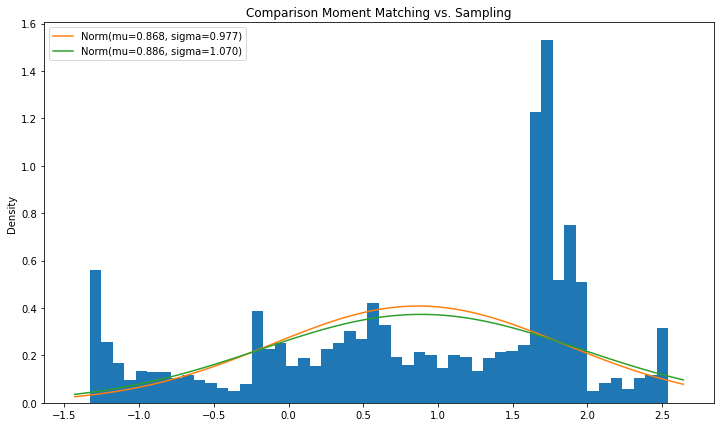

In [11]:
# Deisenroth et. al. Moment Matching using RBF for a single state dimension
# Original Eq. are much complicated as they have to regard state covariance

def moment_match_mu_next(model, mu_in, sigma_in):
    nus = model.X_train_ - mu_in # Eq. (16)
    ls_square = model.kernel_.length_scale # Eq. (6)
    var_in = sigma_in**2
    q_a = np.exp(-nus * (ls_square + var_in) ** -1  * nus) / (var_in * ls_square**-1 + 1) # Eq. (15)
    return np.sum(q_a * model.alpha_)

def moment_match_sigma_next(model, mu_in, sigma_in, mu_out):
    sigma_sq_out = sigma_in**2 + mu_in**2 - mu_out**2 # Eq. (17)
    return np.sqrt(sigma_sq_out).ravel()[0]

def moment_match(model, mu_in, sigma_in):
    mu_out = moment_match_mu_next(model, mu_in, sigma_in)
    sigma_out = moment_match_sigma_next(model, mu_in, sigma_in, mu_out)
    return mu_out, sigma_out

def sample_match(model, mu_in, sigma_in, samples=2000):
    samps = model.sample_y(norm(mu_in, sigma_in).rvs((samples, 1)))
    return samps.mean(), samps.std(ddof=1)


next_mu_sample, next_sigma_sample = sample_match(model, cur_mu, cur_sigma)
next_mu_mm, next_sigma_mm = moment_match(model, cur_mu, cur_sigma)

print("mu:", next_mu_mm, next_mu_sample)
print("sigma:", next_sigma_mm, next_sigma_sample)
compare_pdfs(output_preds, [norm(next_mu_mm, next_sigma_mm).pdf,
                            norm(next_mu_pred, next_sigma_pred).pdf], "Comparison Moment Matching vs. Sampling",
            labels=[norm_label(next_mu_mm, next_sigma_mm),
                    norm_label(next_mu_pred, next_sigma_pred)])



In [12]:
t0 = time()
mu_pred, sigma_pred = moment_match(model, cur_mu, cur_sigma)
print(f"Mu: {mu_pred:.3f} Sigma: {sigma_pred:.3f} Dura: {time() - t0:.6f} seconds")

Mu: 0.868 Sigma: 0.977 Dura: 0.000250 seconds


In [13]:

for samples in [2000, 1000, 500, 250, 100, 50, 25, 10, 5, 2]:
    t0 = time()
    mu_pred, sigma_pred = sample_match(model, cur_mu, cur_sigma, samples=samples)
    print(f"Samples: {samples:5d} Mu: {mu_pred:6.3f} Sigma: {sigma_pred:6.3f} Dura: {time() - t0:6.6f} seconds")

Samples:  2000 Mu:  0.871 Sigma:  1.037 Dura: 2.731446 seconds


Samples:  1000 Mu:  0.421 Sigma:  1.312 Dura: 0.393812 seconds
Samples:   500 Mu:  0.343 Sigma:  1.261 Dura: 0.072699 seconds
Samples:   250 Mu:  0.923 Sigma:  1.070 Dura: 0.014544 seconds
Samples:   100 Mu:  0.660 Sigma:  1.204 Dura: 0.003513 seconds
Samples:    50 Mu:  0.512 Sigma:  1.276 Dura: 0.002263 seconds
Samples:    25 Mu: -0.048 Sigma:  1.322 Dura: 0.001963 seconds
Samples:    10 Mu:  0.551 Sigma:  0.981 Dura: 0.001711 seconds
Samples:     5 Mu: -1.039 Sigma:  0.621 Dura: 0.001677 seconds
Samples:     2 Mu: -0.056 Sigma:  2.089 Dura: 0.001673 seconds
